Consider linear MLP  
$$
x_\ell = W_\ell x_{\ell-1}, \qquad W_\ell\sim N(0,1/d)^{d\times d}
$$
The following block computes the histogram of norms of output and input ratios $\|x_\ell\|/\|x_0\|$ is highly skewed, and for large $\ell$ converges to a delta at zero (most values are nearly zero)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import jax.numpy as jnp
from jax import jacfwd, random

import numpy as np
from scipy.stats import wishart
from scipy.special import psi, loggamma
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

/var/folders/l3/48qws3395_n8vgpz1xtgcwkr0000gp/T/ipykernel_847/3363352186.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


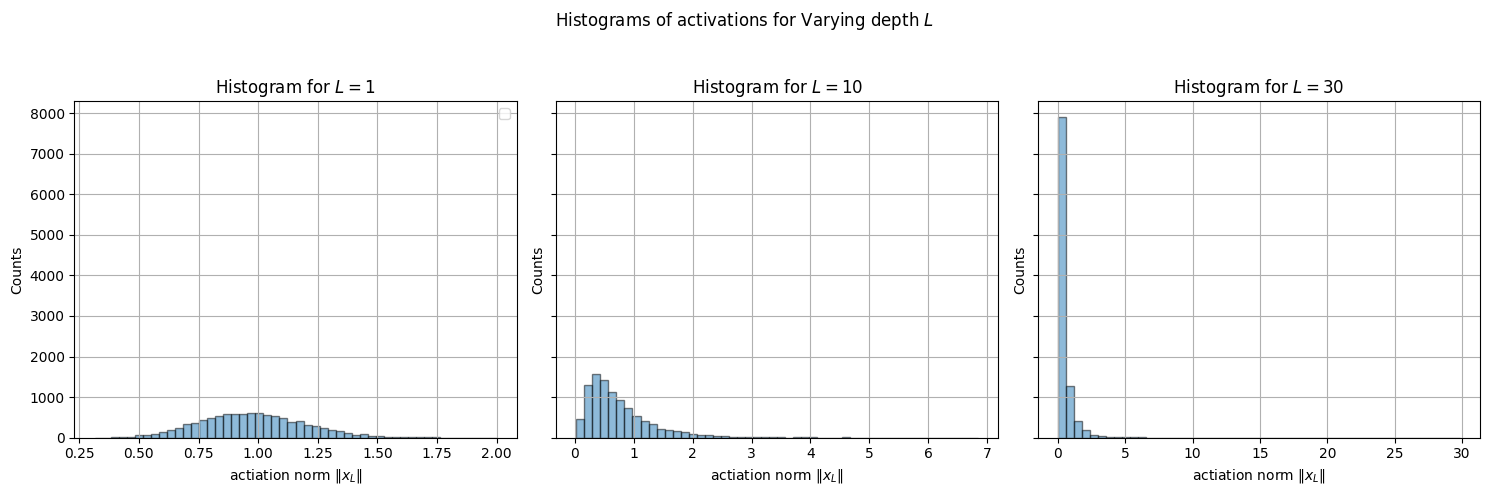

In [2]:


# Constants
N = 10000
d = 10
L_values = [1, 10, 30]

# Setting up the figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=len(L_values), figsize=(15, 5), sharey=True)
fig.suptitle('Histograms of activations for Varying depth $L$')

# Generate data and plot histograms in subplots
for index, L in enumerate(L_values):
    coefs = np.zeros(N)
    for i in range(N):
        P = np.eye(d)
        for l in range(L):
            W = np.random.randn(d, d) * np.sqrt(1.0 / d)
            P = W @ P
        x = np.random.randn(d, 1)
        x = x / np.linalg.norm(x)
        y = P @ x
        coefs[i] = np.linalg.norm(y) 
    
    ax = axes[index]
    ax.hist(coefs, bins=50, alpha=0.5,edgecolor='black')
    ax.set_title(f'Histogram for $L={L}$')
    ax.set_xlabel('actiation norm $\\|x_L\\|$')
    ax.set_ylabel('Counts')
    ax.grid(True)

# Adding a legend
axes[0].legend()
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to make room for the title
plt.show()


In a linear MLP with normalized forward pass: 
$$
x_\ell = W_\ell x_{\ell-1}/ \|W_\ell x_{\ell-1}\|_{rms}, \qquad \|x\|_{rms}\sqrt{\|\frac1d\sum_{i=1}^dx_i^2}
$$
the activations for two different inputs become increasingly aligned, as shown below

<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:28: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:28: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\e'
/var/folders/l3/48qws3395_n8vgpz1xtgcwkr0000gp/T/ipykernel_7054/3985767608.py:27: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Layer $\ell$')
/var/folders/l3/48qws3395_n8vgpz1xtgcwkr0000gp/T/ipykernel_7054/3985767608.py:28: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$\\sin^2\\theta(x_\ell,y_\ell)$')
/var/folders/l3/48qws3395_n8vgpz1xtgcwkr0000gp/T/ipykernel_7054/3985767608.py:30: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Sine-squared between $x_\ell$ and $y_\ell$')


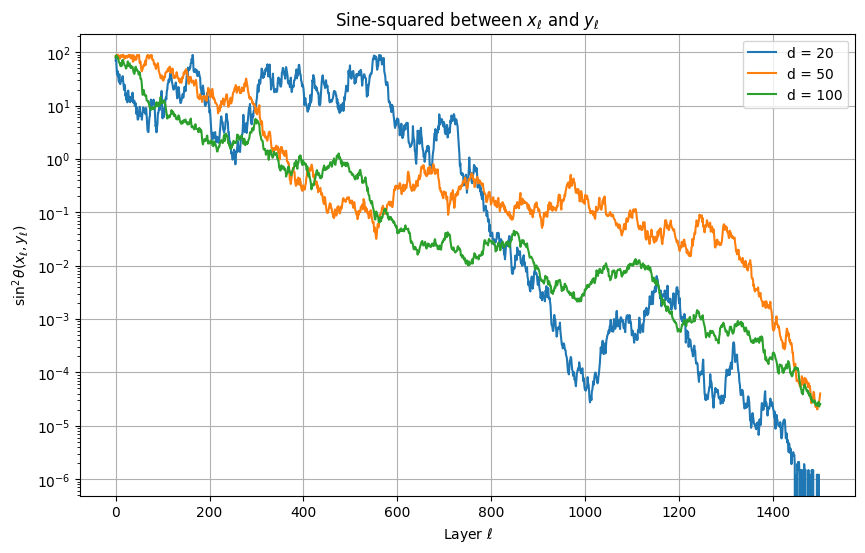

In [109]:
def angle_between_vectors(v1, v2):
    v1 = v1.flatten()
    v2 = v2.flatten()
    cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    cosine_angle = np.abs(cosine_angle)
    angle = np.arccos(np.clip(cosine_angle, -1, 1))
    return np.degrees(angle)

def rms_norm(x):
    return np.sqrt(np.mean(x**2))

plt.figure(figsize=(10, 6))
for d in [20, 50, 100]:
    L = 1500
    thetas = np.zeros(L+1)
    x = np.random.randn(d, 1)
    y = np.random.randn(d, 1)
    thetas[0] = angle_between_vectors(x,y)
    for l in range(L):
        W = np.random.randn(d, d) * np.sqrt(1.0 / d)
        x = W @ x / rms_norm(W @ x)
        y = W @ y / rms_norm(W @ y )
        thetas[l+1] = angle_between_vectors(x, y)

    # Plotting the results
    plt.plot(range(L+1),thetas, label=f'd = {d}')
plt.xlabel('Layer $\ell$')
plt.ylabel('$\\sin^2\\theta(x_\ell,y_\ell)$')
plt.yscale('log')
plt.title('Sine-squared between $x_\ell$ and $y_\ell$')
plt.legend()
plt.grid(True)
plt.show()


Check derivation for backward Jaccobians is correct with numerical tests

In [6]:


def rms_norm(x):
    return jnp.sqrt(jnp.mean(x**2))

def mlp_forward(x, matrices):
    for W in matrices:
        x = jnp.dot(W, x)
    return x / rms_norm(x)

def generate_gaussian_matrices(key, d, L):
    keys = random.split(key, L)
    return [random.normal(k, shape=(d, d))/jnp.sqrt(d) for k in keys]

def analytical_jacobian(x, matrices):
    d = x.shape[0]
    # Compute forward pass
    P = jnp.eye(d)
    for W in matrices:
        P = W @ P 
        # x = jnp.dot(W, x)
    x = P @ x 
    rms = rms_norm(x)
    x_normalized = x / rms
    # Compute the analytical Jacobian at the output
    part1 = (1.0 / rms) * jnp.eye(d) @ P
    part2 =  (1.0 / rms) * (1.0/d) * jnp.outer(x_normalized, x_normalized) @ P 
    # print("Part 1 :\n", part1)
    # print("Part 2 :\n", part2)
    jac_norm =  (1.0 / rms) * (jnp.eye(d) - (1.0/d) * jnp.outer(x_normalized, x_normalized))
    return jac_norm @ P 

# Let's pick a random x and dimension d
d = 3
L = 20  # Number of layers

key = random.PRNGKey(0)
x = random.normal(key, shape=(d,))

# Generate Gaussian matrices
keys = random.split(key, L)
matrices = generate_gaussian_matrices(keys[0], d, L)

# Compute the Jacobian using JAX
numerical_jacobian = jacfwd(lambda x: mlp_forward(x, matrices))(x)

# Compute the Jacobian analytically
analytical_jacobian_result = analytical_jacobian(x, matrices)

# Print both to compare
print("Numerical Jacobian from JAX:\n", numerical_jacobian)
print("\nAnalytical Jacobian:\n", analytical_jacobian_result)

# Check if they are close
print("\nAre the two Jacobians close?", jnp.allclose(numerical_jacobian, analytical_jacobian_result))


Numerical Jacobian from JAX:
 [[-1.7838071e-05 -4.4996599e-05  3.0458761e-05]
 [ 3.0026906e-05  7.6050877e-05 -5.2817832e-05]
 [ 3.4464811e-06  8.8903289e-06 -6.0456932e-06]]

Analytical Jacobian:
 [[-1.7623184e-05 -4.4499287e-05  3.0630767e-05]
 [ 3.0310688e-05  7.6745637e-05 -5.2941727e-05]
 [ 3.5634198e-06  9.0549383e-06 -6.1069513e-06]]

Are the two Jacobians close? False


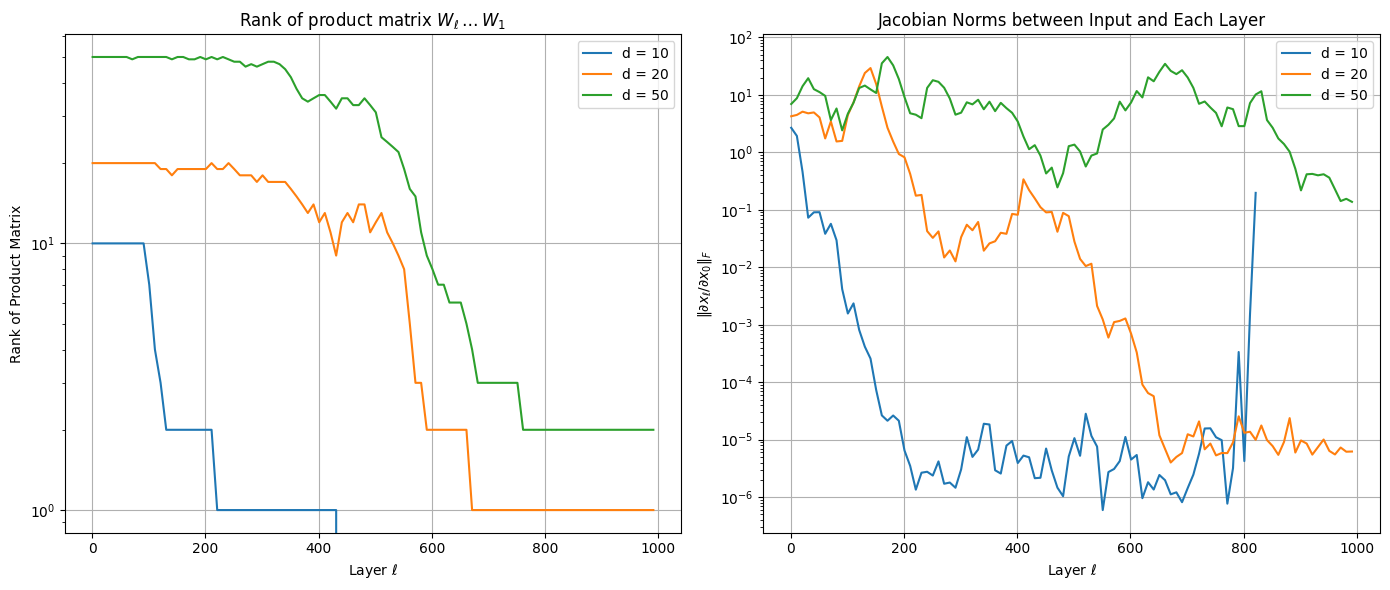

In [8]:



key = random.PRNGKey(0)

# Prepare to plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
L = 1000
Ls = range(1, L+1,10)
for d in [10, 20, 50]:
    x_key, matrix_key = random.split(key)
    x = random.normal(x_key, shape=(d,))
    matrices = generate_gaussian_matrices(matrix_key, d, L)

    jac_norms = []
    product_ranks = []
    for l in Ls:
        J = analytical_jacobian(x, matrices[:l])
        P = reduce(jnp.dot, matrices[:l])
        r = jnp.linalg.matrix_rank(P,tol=1e-10)
        product_ranks.append(r)
        jac_norms.append(jnp.linalg.norm(J))

    # Plotting Jacobian norms
    axes[1].plot(Ls, jac_norms, label=f'd = {d}')
    # Plotting product ranks
    axes[0].plot(Ls, product_ranks, label=f'd = {d}')

axes[0].set_xlabel('Layer $\\ell$')
axes[0].set_ylabel('Rank of Product Matrix')
axes[0].set_title('Rank of product matrix $W_\\ell\\dots W_1$')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True)


axes[1].set_xlabel('Layer $\\ell$')
axes[1].set_ylabel('$\\| \\partial x_\\ell / \\partial x_0 \\|_F$')
axes[1].set_title('Jacobian Norms between Input and Each Layer')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Batch normalization 

The problem of $\log\det(U^\top A^2 U)$ can be approached with making it Gaussian and inverting it. 
Let $W$ be a $d\times n$ with elements drawn from $N(0,1/d).$ Note that its SVD decomposition $W = U S V^\top,$ where $U\in R^{d\times n}$ is a random roation of $k$ dimension. Thus, we can state that $V S U^\top U^\top A^\top A U S V^\top$ is equal in distribution to $W^\top A^2 W.$ Furthermore, because $V$ is only a rotation in $R^n$, this is equal in distribution to $S U^\top U^\top A^\top A U S.$ Assuming $S$ is full-rank, we have $U^\top U^\top A^2 U$ is equal in spectral distribution to $V^\top S^{-1}S U\top U^\top A^\top A U S S^{-1} V.$ And altogether 
$$ 
\begin{align*}
\log\det(U^\top A^\top A U) = \log\det(W^\top A^\top A W) - \log\det(W^\top W) \qquad (1)
\end{align*}
$$

Now, let $Y = A W$ which is $d\times n$ matrix, and is Gaussian and $n\le d$. Let us compute its covariance. 
Note that each column of $Y$ is an independent of the others $col_j(Y) = A W_j.$ Thus, $E col_i(Y)col_j(Y)=0$ for $i\neq j.$ Now, for the diagonal elements we have $\|A\|_F^2 E g_i^2$, thus we have 
$$
\begin{align*}
E Y^\top Y = \|A\|_F^2 I_n \implies Y \in R^{d\times n}, \text{ each row drawn iid from } N(0, \|A\|_F^2 I_n / d), \qquad (2) \\
E W^\top I_nW = \|A\|_F^2 I_n \implies W \in R^{d\times n},  \text{ each row drawn iid from } N(0, I_n )
\end{align*}
$$
Thus
$$
\begin{align*}
\log\det(Y^\top Y/d) - \log\det(\|A\|_F^2 I_n / d) \sim N(-n/2d, 2n/d) \qquad (3)\\
\log\det(W^\top W/d) - \log\det(I_n) \sim N(-n/2d, 2n/d) \qquad (3^*)
\end{align*}
$$
thus we can conclude 
$$
\begin{align*}
\implies E (\log\det(Y^\top Y/d) - \log\det(\|A\|_F^2 I_n / d)) - E(\log\det(W^\top W/d)) = 0\\
\implies E (\log\det(Y^\top Y/d))- E(\log\det(W^\top W/d)) = \log\det(\|A\|_F^2 I_n / d) = n\log(\|A\|_F^2 / d) 
\end{align*}
$$
Thus, all-in-all we have 
$$
E \log\det(U^\top A^\top A U) = E (\log\det(Y^\top Y))- E(\log\det(W^\top W)) = n\log(\|A\|_F^2/d) \qquad (4)
$$
where we cancelled $n\log(1/d)$ from the two terms inside the log. 

If $\frac1d Y^\top Y = \frac1d \sum_{i=1}^d y_i y_i^\top N(0, \|A\|^2_F/d^2).$ Thus rows of $Y$ are drawn from  $N(0, \|A\|^2_F/d^2).$

In [119]:
X = np.random.randn(n, d) / np.sqrt(d)
C = X @ X.T
logdet(C), -n**2/2/d

(-0.7540180426857299, -0.25)

(array([ 22.,  36., 111., 205., 248., 191., 117.,  50.,  18.,   2.]),
 array([-31.56896953, -31.09263894, -30.61630834, -30.13997775,
        -29.66364716, -29.18731656, -28.71098597, -28.23465537,
        -27.75832478, -27.28199419, -26.80566359]),
 <BarContainer object of 10 artists>)

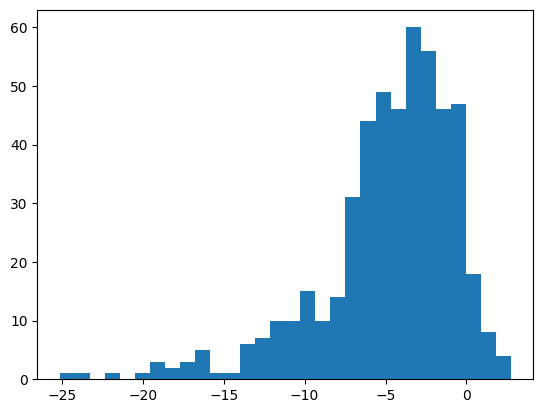

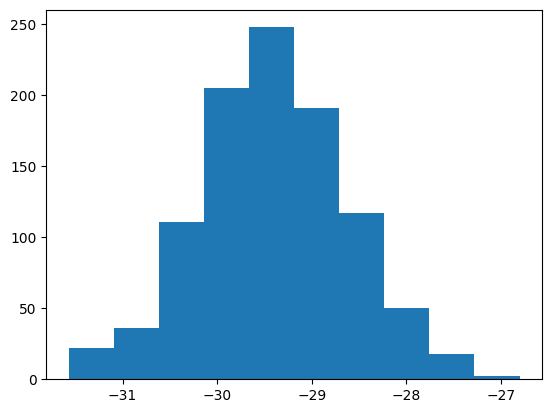

In [151]:
plt.hist(np.log(vals**2),bins=30)
plt.figure()
plt.hist(log_dets)

In [152]:
n, d = 1, 500
vals = np.random.randn(d) ** (2)
vals = vals / np.mean(vals**2)
A = np.diag(vals)
# A = np.eye(d)|
# A = np.random.rand(d, d)

log_dets = []
log_dets2 = []
for _ in range(1000):
    W = np.random.randn(d, n) / np.sqrt(d)
    Y = A @ W 
    log_dets.append(logdet( Y.T @ Y))
theory1 = n**2 / d * np.mean(np.log(vals**2))
theory2 = n**2 / d * np.mean(np.log(vals**2)) - n**2 / 2 / d
np.mean(log_dets), theory1, theory2 #np.mean(np.log(vals**2)) - n**2 / d / 2

(-1.0921841717457437, -0.008847807276702339, -0.009847807276702338)

### verify equation (1) 

In [62]:
def logdet(C):
    return np.log(np.linalg.det(C))
    
n, d = 5, 20
A = np.random.randn(d, d)
A2 = A @ A.T
W = np.random.rand(d, n) / np.sqrt(d)
U, S, Vh = np.linalg.svd(W, full_matrices=False)

UA2U = U.T @ A2 @ U
WA2W = W.T @ A2 @ W
WTW = W.T @ W

print(logdet(UA2U), logdet(WA2W)-logdet(WTW))
if np.allclose(logdet(UA2U), logdet(WA2W)-logdet(WTW)):
    print("they are close")

14.425794506671904 14.425794506671902
they are close


### verifying equation (2)

In [61]:
n, d = 5, 50
A = np.diag(np.random.randn(d))
A = np.random.rand(d, d)

Cs = []
for _ in range(100000):
    W = np.random.randn(d, n) / np.sqrt(d)
    Y = A @ W 
    C = Y.T @ Y
    Cs.append(C)
empirical = np.mean(np.stack(Cs),axis=0)
theory = np.sum(A**2) / d * np.eye(n)
empirical, theory
np.sum((empirical-theory)**2)

0.07753230481379372

In [27]:
def logdet(A):
    return np.log(np.linalg.eigvalsh(A)).sum()

def rms_norm(A):
    return np.mean(A**2)**0.5
n, d = 20, 100

X = np.random.rand(d, n)
row_norms = np.mean(X**2,axis=1)**0.5
X = np.diag(row_norms**(-1)) @ X 
W = np.random.randn(d, d) / np.sqrt(d)
A = W @ X 
row_norms = np.mean(A**2,axis=1)**0.5
BN = np.diag(row_norms**(-1))
Y = BN @ A 
CX = X.T @ X / d
CA = A.T @ A / d
CY = Y.T @ Y / d

approx = logdet(CX) - n / 2 / d - np.sum(np.log(row_norms**2)) * n / d

rms_norm(A), rms_norm(X), rms_norm(Y)
logdet(CX), logdet(CA), logdet(CY), logdet(BN @ BN)

(-25.791048109964837,
 -28.862101637433746,
 -15.75308759946668,
 48.61669415619262)

# Symmetry of determinant 

In [21]:
import numpy as np

def logdet(X):
    return np.log(np.linalg.det(X))
    # s = np.linalg.svd(X).S
    # return np.sum(np.log(s))

# Set dimensions
d = 10  # Total dimension
k = 3  # Dimension of subspace spanned by V

# Generate a random d x d matrix X
X = np.random.rand(d) ** (-1)
X = X / np.mean(X)
X = np.diag(X)
X2 = np.diag(np.ones(d))

R = np.linalg.svd(np.random.rand(d,d),).U
U = R[:,:k]

C1 = (X @ U).T @ (X @ U)
C2 = (X2 @ U).T @ (X2 @ U)
logdet(C1), logdet(C2)

(-14.858570534221155, 2.2204460492503107e-15)

In [2]:
import numpy as np


# Set dimensions
d = 5  # Total dimension
k = 3  # Dimension of subspace spanned by V

# Generate a random d x d matrix X
X = np.random.randn(d, d)
X = np.diag(np.random.randn(d))

R = np.linalg.svd(np.random.rand(d,d),).U
U = R[:,:k]
V = R[:,:(d-k)]

# Compute A = X V and B = X U
A = X @ V
B = X @ U

# Compute Gram matrices AA^T and BB^T
CA = A.T @ A
CB = B.T @ B
CX = X.T @ X

# Compute determinants
dx = np.linalg.det(CX)
da = np.linalg.det(CA)
db = np.linalg.det(CB)

# Print results
print("det(X^T X):", dx)
print("det(A A^T):", da)
print("det(B B^T):", db)
print("Product of det(A A^T) and det(B B^T):", da * db)

# # Verify the equality
# assert np.isclose(dx, da * db), "The determinants do not match!"
# print("Verification passed: det(X^T X) == det(A A^T) * det(B B^T)")


det(X^T X): 0.00013872212170281385
det(A A^T): 0.4431369271945879
det(B B^T): 0.33680052776238534
Product of det(A A^T) and det(B B^T): 0.14924875095013893


# Properties of Wishart matrices 

If $W$ is $d\times n$ for $d\ge n$, and its elements are drawn iid from $N(0,1),$ then distribution of $\det(W)$ is given by multiplication of chi-squared random variables with degrees $d$ down to $d-n+1.$: 
$$
\det(W^\top W)\sim \chi^2_{d}\chi^2_{d-1}\dots \chi^2_{d-n+1},\qquad   W \in R^{d\times n}, d\ge n, W_{ij}\sim N(0,1/d)
$$

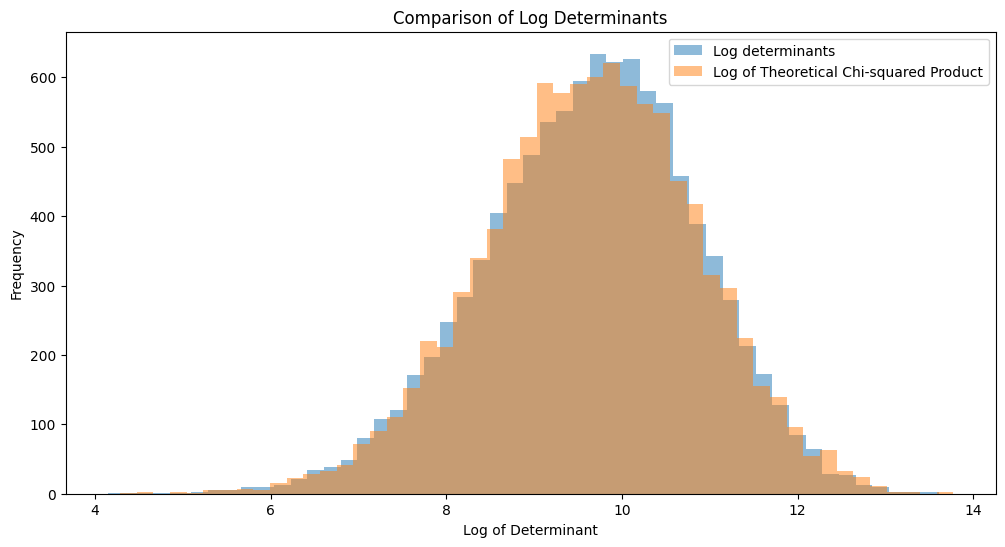

In [12]:

# Parameters
d = 10
n = 5
num_matrices = 10000

# Simulation
matrices = np.random.normal(0, 1, (num_matrices, d, n))

logs_of_dets = []
for W in matrices:
    # compute log-det by sum of log-eigenvalues
    e = np.linalg.eigvalsh(W.T @ W)
    log_det = np.sum(np.log(e))  
    logs_of_dets.append(log_det)
log_det_real = np.array(logs_of_dets)

log_chi2 = np.zeros((n, num_matrices))
for i in range(n):
    log_chi2[i, :] = np.random.chisquare(df=d-i, size=(num_matrices))
log_det_theoretical = np.sum(np.log(log_chi2),axis=0)
log_det_theoretical

# Plotting
plt.figure(figsize=(12, 6))
plt.hist(log_det_real, bins=50, alpha=0.5, label='Log determinants')
plt.hist(log_det_theoretical, bins=50, alpha=0.5, label='Log of Theoretical Chi-squared Product')
plt.xlabel('Log of Determinant')
plt.ylabel('Frequency')
plt.title('Comparison of Log Determinants')
plt.legend()
plt.show()


Based on Wishart distribution we have 
$E \log\det(W^\top W) = n \log(2) - n \log(d) + \sum_{i=1}^n \psi(\frac{d-i+1}{2})$
Using the approximations for di-gamma function $\psi$ and Taylor series of $\log(1+x)$, we can approximate it by 
$$
E \log\det(W^\top W) = -\frac{n^2}{2d} - \frac{n^3}{6d^2} - \frac{n^4}{3d^3} + O((n^5/d^4))
$$

In [75]:
# Simulate Wishart matrices
n, d = 50,50
n_simulations = 1000
log_dets = []
for _ in range(n_simulations):
    W = np.random.randn(d, n) / np.sqrt(d)
    log_det = np.sum(np.log(np.linalg.det(W.T @ W)))
    log_dets.append(log_det)
empirical = np.mean(log_dets)

theory_exact = n * np.log(2/d) + sum(psi((d-i)/2.0) for i in range(n))
theory_approx1 = - n**2/d/2 - n**3/d**2/6 - n**4/d**3/3
empirical/n, theory_exact/n, theory_approx1/n

(-1.039821969386148, -1.041857856989307, -1.0)

prove the following. 
A central limit theorem is established for the log determinant of $W^\top W$ where $W$ is a $d\times n$ matrix with elements drawn iid from $N(0,1/d)$ in the high-dimensional setting where the dimension $n$ grows with the sample size $d$ with the only restriction that $n(d) \leq d$. In the case when $\lim_{n \to \infty} \frac{n(d)}{d} = r$ for some $0 \leq r < 1$, the central limit theorem shows

$$
\frac{\log \det (W^\top W) - \sum_{i=1}^{d} \log \left(1 - \frac{i}{d}\right) }{\sqrt{-2\log(1-n/d)}} \xrightarrow{distr.} N(0,1) \text{ as } n \to \infty.
$$

When $n/d$ is sufficiently small, we have $\mu = -n^2/2d$ and variance $2n/d$. For individual eigenvalues, we have $\mu = -n/2d$ and variance $2/d.$ Thus, under the assumption that as $n,d$ go larger, the eigenvalue empirical distirbution converges to a distribution, and that we can assume individual eigenvalues are iid samples from this ESD, we can say 
$$
P(\log\lambda) = N(-\frac{n}{2d}, \frac{n}{d})
$$



In [113]:
# Simulate Wishart matrices
vars = []
means = []
n, d = 10, 50
for _ in range(1000):
    W = np.random.randn(d, n) / np.sqrt(d)
    eigs = np.linalg.eigvalsh(W.T @ W)
    log_eigs = np.log(eigs)
    # log_eigs = np.random.randn(n)
    # log_eigs[0] -= log_eigs[1]
    means.append(np.mean(log_eigs))
    vars.append(np.var(log_eigs))

# expectation of variance roughly variance of mean * n 
# np.mean(vars), np.var(means) * n**2 / 2
np.mean(means), -n/2/d, np.var(means), 2/d/n, np.mean(vars), n/d

# plt.hist(log_eigs, 50)


(-0.1155198221380701,
 -0.1,
 0.004245307215233366,
 0.004,
 0.2457226930613616,
 0.2)

(array([0.04726535, 0.04726535, 0.03544901, 0.05908169, 0.07089803,
        0.07089803, 0.07089803, 0.08271437, 0.08271437, 0.0945307 ,
        0.0945307 , 0.08271437, 0.0945307 , 0.10634704, 0.08271437,
        0.10634704, 0.0945307 , 0.10634704, 0.0945307 , 0.08271437,
        0.11816338, 0.0945307 , 0.0945307 , 0.08271437, 0.08271437,
        0.08271437, 0.07089803, 0.05908169, 0.03544901, 0.03544901]),
 array([-9.71521245, -9.29206951, -8.86892658, -8.44578364, -8.0226407 ,
        -7.59949777, -7.17635483, -6.7532119 , -6.33006896, -5.90692602,
        -5.48378309, -5.06064015, -4.63749721, -4.21435428, -3.79121134,
        -3.3680684 , -2.94492547, -2.52178253, -2.09863959, -1.67549666,
        -1.25235372, -0.82921078, -0.40606785,  0.01707509,  0.44021803,
         0.86336096,  1.2865039 ,  1.70964684,  2.13278977,  2.55593271,
         2.97907565]),
 <BarContainer object of 30 artists>)

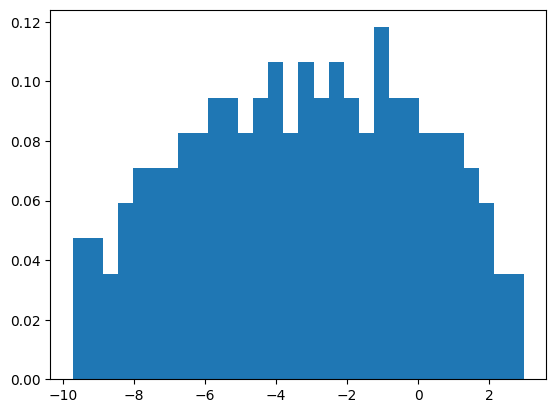

In [142]:
n, d = 200, 1000
matrices = [np.random.randn(d,d)/np.sqrt(d) for i in range(30)]
matrices[0] = np.random.randn(n, d) / np.sqrt(d)
P = reduce(np.dot, matrices)
eigs = np.linalg.eigvalsh(P @ P.T)
eigs = np.log(eigs)
plt.hist(eigs,30,density=True)


In [141]:
from scipy.stats import marchenko_pastur


lambda_ratio = n / d

# Marchenko-Pastur PDF
a = (1 - np.sqrt(lambda_ratio))**2
b = (1 + np.sqrt(lambda_ratio))**2
x = np.linspace(a, b, 1000)
pdf_values = marchenko_pastur.pdf(x, lambda_ratio)

# Plot the theoretical PDF
plt.plot(x, pdf_values, label='Marchenko-Pastur PDF')


ImportError: cannot import name 'marchenko_pastur' from 'scipy.stats' (/opt/miniconda3/lib/python3.12/site-packages/scipy/stats/__init__.py)

In [85]:
vars = []
means = []
n, d = 10, 200
for _ in range(1000):
    log_eigs = np.random.choice(eigenvalues, n)
    means.append(np.mean(log_eigs))
    vars.append(np.var(log_eigs))

np.mean(vars), np.var(means) * (n-1)


(0.47454283158817584, 0.48184427534360863)

(array([ 57., 105., 142., 178., 217., 246., 278., 296., 287., 194.]),
 array([-1.98446688, -1.68795271, -1.39143855, -1.09492438, -0.79841021,
        -0.50189604, -0.20538187,  0.09113229,  0.38764646,  0.68416063,
         0.9806748 ]),
 <BarContainer object of 10 artists>)

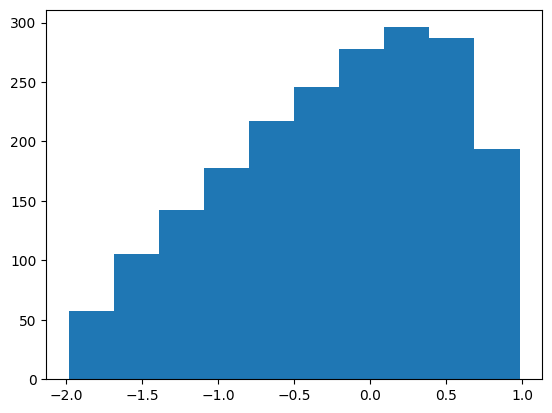

In [83]:
n, d = 2000, 5000
# Generate W matrix
W = np.random.randn(d, n) / np.sqrt(d)

# Calculate W'W/d
M = W.T @ W

# Eigenvalues of M
eigenvalues = np.log(np.linalg.eigvalsh(M))

plt.hist(eigenvalues)

In [4]:
n, d = 
# Simulate Wishart matrices
n_simulations = 10
log_dets = []
for _ in range(n_simulations):
    matrices = [np.random.randn(d1,d2)/np.sqrt(d2) for d1,d2 in zip(ds[:-1],ds[1:])]
    P = reduce(np.dot, matrices)
    log_det = np.sum(np.log(np.linalg.det(P)**2))
    log_dets.append(log_det)

theory_exact = n * np.log(2/d) + sum(psi((d-i)/2.0) for i in range(n))
theory_approx1 = -n**2/2/d 
np.mean(log_dets)
    

[-108.06141457512032,
 -89.8094568733145,
 -110.03677363622604,
 -107.64509175725547,
 -108.55597755107759,
 -101.49434145090777,
 -94.74289304240287,
 -113.30762394892508,
 -106.02484934416573,
 -99.25987296111826]

In [111]:




# Parameters
D = 5  # Dimension of the Wishart distribution
nu = 10  # Degrees of freedom
np.random.seed(0)  # Seed for reproducibility

# Scale matrix (random positive definite matrix)
np.random.seed(42)  # Seed for reproducibility
A = np.random.randn(D, D)
Psi = np.dot(A, A.T)  # Making sure Psi is positive definite
Psi = np.eye(D) / D

# Simulate Wishart matrices
n_simulations = 100
log_dets = []
for _ in range(n_simulations):
    Lambda = wishart.rvs(df=nu, scale=Psi)
    log_det = np.log(np.linalg.det(Lambda))
    log_dets.append(log_det)

# Empirical mean of log determinants
empirical_mean = np.mean(log_dets)

# Theoretical expectation calculation
log_det_psi = np.log(np.linalg.det(Psi))
theoretical_mean = D * np.log(2) + log_det_psi + sum(psi((nu - i + 1) / 2) for i in range(1, D + 1))

empirical_mean, theoretical_mean


(1.5826859728549312, 1.5955935795960645)

In [25]:
n, d = 2, 10
n_simulations = 1000
log_dets = []
for _ in range(n_simulations):
    W = np.random.randn(n, d) / np.sqrt(d)
    Lambda = W @ W.T
    log_det = np.log(np.linalg.det(Lambda))
    log_dets.append(log_det)
def log_det_theory(n, d):
    return n * np.log(2) - n * np.log(d) + sum(psi((d-i)/2.0) for i in range(n))

np.mean(log_dets), log_det_theory(n,d)


(-0.34711186838751074, -0.3238872300768718)

Define $Y:=\log(X)$ where $X = \frac1k\sum_{i=1}^k g_i^2$ is a normalized, chi-squared random variable. 
Thus we have 
$$
E e^{m Y} = E e^{m \log(X)} = 
E X^{m} = k^{-m} E (k X )^m = k^{-m} 2^m \frac{\Gamma(k/2+m)}{\Gamma(k/2)}
$$
if $m\ge 0$ then the gamma ratio is $(k/2+m)\dots (k/2+1)$ while if $-k/2 < m < 0$ then the ratio is inverse of $k/2 (k/2-1)\dots (k/2+m+1).$ If we factorize $k/2,$ for positive we have products of $1(1+2/k)(1+4/k)\dots (1-2(m-1)/k)$ while for negative we have $1(1-2/k)(1-4/k)\dots(1-2(m-1)/k).$ Since we always have $\log(1+x)\le x$ for all $x\ge -1$, thus as long as $m\ge -k/2 + 1, $ we have:
$$
\frac{\Gamma(k/2-m)}{\Gamma(k/2)} \le e^{-2/k - \dots - 2(m-1)/k} = e^{-m(m-1)/k}, 
\quad
\frac{\Gamma(k/2+m)}{\Gamma(k/2)} \le e^{2/k + \dots + 2(m-1)/k} = e^{m(m-1)/k},
$$
Putting it al together we have
$$
E e^{m Y} \le (2/ k)^m e^{m |m-1|/k} , \qquad m \ge -k/2 + 1
$$
, is sub-expoential as
$$
P(|Y|\ge t ) \le 2\exp(-\sqrt{n} t)
$$
If that's true, then for $K = \sqrt{n}$ in sub-exponential random variable we have  
$$
E(e^{\lambda (Y-E Y)}) \le e^{\lambda^2/n} \text{ for } -1/\sqrt{n} \le \lambda \le 1/\sqrt{n}
$$

expectation =  -1.2779854872967507  STD Y =  2.230296321006185
expectation slope =  9.544570854024194
Prob slope =  -0.5664595653794173


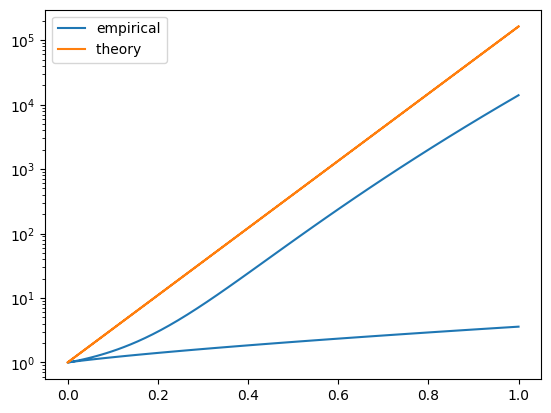

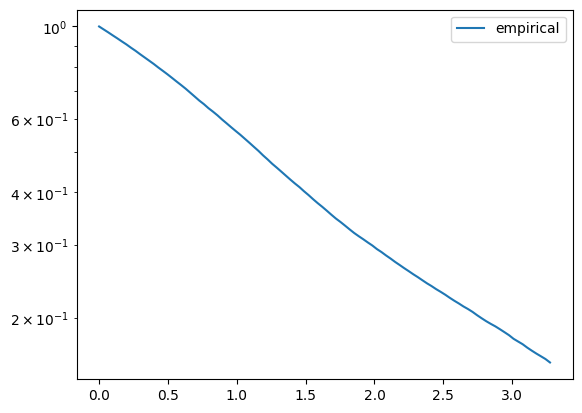

In [43]:
# Set parameters
n = 1 # degrees of freedom of the chi-squared distribution
num_samples = 50000  # number of samples to generate
X = np.random.randn(num_samples, n)
Y = np.log(np.mean(X**2, axis=1))
EY = np.mean(Y)
STDY = np.std(Y)

lambdas = np.linspace(-1,1,100)
exp = np.zeros_like(lambdas)
for i,l in enumerate(lambdas):
    exp[i] = np.mean(np.exp(l*(Y-EY)))

ts = np.linspace(0, max(Y)*1.1, 100)
Ps = np.zeros_like(ts)
for i,t in enumerate(ts):
    Ps[i] = np.mean(np.abs(Y )>= t)

print('expectation = ',EY, ' STD Y = ', STDY)
exp_theory = np.exp((lambdas)**2 * 12 / n  )
slope = np.log(np.max(exp)/np.min(exp)) / (np.max(lambdas**2))
print('expectation slope = ', slope)
plt.plot(lambdas**2, exp, label='empirical')
plt.plot(lambdas**2, exp_theory, label='theory ')
plt.yscale('log')
plt.legend()

plt.figure()
plt.plot(ts, Ps, label='empirical')
slope = np.log(Ps[-1])/ts[-1]
print('Prob slope = ', slope)
plt.yscale('log')
plt.legend()


In [127]:
Y[Y<=0]

array([-2.93728632, -2.09587083, -1.07497474, ..., -1.00655795,
       -2.58463691, -1.8073442 ])

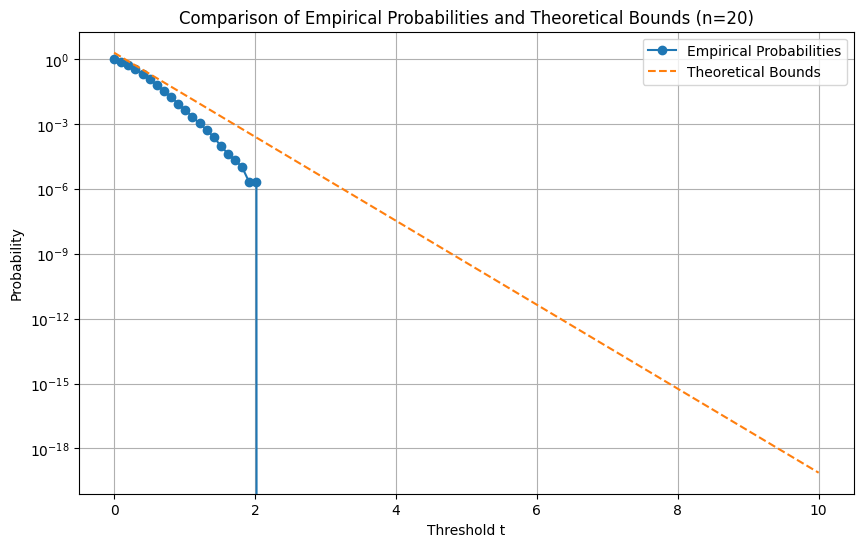

In [120]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_Y(n, num_samples):
    # Generate samples from a normalized chi-squared distribution
    S = np.random.chisquare(n, size=num_samples)
    X = S / n
    Y = np.log(X)
    return Y

def empirical_probability(Y, threshold):
    return np.mean(np.abs(Y) >= threshold)

def theoretical_bound(n, t):
    return 2 * np.exp(-n**0.5 * t  )

# Set parameters
n = 20  # degrees of freedom of the chi-squared distribution
num_samples = 500000  # number of samples to generate
thresholds = np.linspace(0, 10, 100)  # range of threshold values

# Simulate Y values
Y = simulate_Y(n, num_samples)

# Compute empirical probabilities and theoretical bounds
emp_probs = [empirical_probability(Y, t) for t in thresholds]
theo_bounds = [theoretical_bound(n, t) for t in thresholds]

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, emp_probs, label='Empirical Probabilities', marker='o')
plt.plot(thresholds, theo_bounds, label='Theoretical Bounds', linestyle='--')
plt.xlabel('Threshold t')
plt.ylabel('Probability')
plt.yscale('log')
plt.title(f'Comparison of Empirical Probabilities and Theoretical Bounds (n={n})')
plt.legend()
plt.grid(True)
plt.show()
